# 读取模型输出数据并统计每个高程区间

In [1]:
import xarray as xr
import pandas as pd
# 使用open_dataset函数打开NetCDF文件
start_date = "2021-08-20"
end_date = "2022-09-10"
data = xr.open_dataset("/home/rice/cosipy/data/output/kqgr_test_20210607-20240925.nc").sel(time=slice(start_date, end_date))

import numpy as np
import pandas as pd

# 定义海拔带的区间
start, end, step = 5500, 5800, 30
bins = np.arange(start, end + step, step)  # 创建分段区间
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]  # 区间标签
# 时间筛选范围


# 创建一个包含海拔带标签的 DataFrame
data_dict = {
    "H_zone": bin_labels,  # 海拔带的区间标签
    "MB": [0] * len(bin_labels),  # 初始化 MB 列，值为空 (或可以初始化为其他默认值)
    "count": [0] * len(bin_labels)  # 用于统计每个海拔带的点数
}

# 创建 DataFrame
model_result = pd.DataFrame(data_dict)

# 假设 data 是一个 xarray Dataset，并包含 lat, lon 和 HGT 信息
# 示例：遍历所有经纬度，获取对应经纬度的海拔值，并更新 MB 列

i = 0
for lat in data["lat"]:  # 遍历纬度
    for lon in data["lon"]:  # 遍历经度
        # 获取对应经纬度的 HGT 值
        ds_tmp = data.sel(lat=lat, lon=lon).sum(dim='time')
        value = ds_tmp['HGT'].values  # 获取 HGT 值
        mask = ds_tmp['MASK'].values
        # 判断对应的海拔带
        if mask == 1:  # 只考虑有效数据
            if start <= value <= end:
                zone_index = np.digitize(value, bins) - 1  # 找到区间索引
                h_zone = bin_labels[zone_index]  # 获取对应区间标签
                
                # 获取该经纬度点的 MB 值，跳过 NaN 值
                mb_value = ds_tmp['MB'].values
                print(mb_value)
                # 检查 mb_value 是否是 NaN，若是则跳过该点
                if not np.isnan(mb_value):
                    # 更新 MB 列的值并增加计数
                    model_result.loc[model_result["H_zone"] == h_zone, "MB"] += mb_value  # 累加 MB 值
                    model_result.loc[model_result["H_zone"] == h_zone, "count"] += 1  # 计数当前海拔带的点数

# 计算每个海拔带的 MB 平均值
model_result["MB_avg"] = model_result["MB"] / model_result["count"]  # MB 列除以 count，得到平均值




0.6037433855646924
0.5613949938636853
0.2727567433388629
0.42626697064168256
0.4841996381338708
0.4330215877340767


/tmp/ipykernel_7548/2498025255.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60374339]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  model_result.loc[model_result["H_zone"] == h_zone, "MB"] += mb_value  # 累加 MB 值


0.35786980125011325
0.24145240576399024
0.2596087875633213
0.2583429906166639
0.22878150891437532
0.1891558399268642
0.1843590969986899
0.14026067881562398
0.13872392040882622
0.1553139185736334
0.11117294358607102
0.04362240097483398
-0.044846481341092294
0.1122536731210046
0.09695870340552112
0.1030351512038784
0.06695431715796785
-0.04146767385125924
-5.019252676527069
-4.988792554588081
0.08907776240077793
0.04719153352490281
0.03792380147779487
0.012712754749105666
-5.054429109738396
-5.0868732447053855
-5.132536239097668
-5.106804141789924
0.01950643144908471
-0.012685335680056892
-0.0596048581969775
-4.998312582138726
-4.957739559308081
-5.024098247220193
-5.125909820674508
-0.06959071526960704
-5.08885415728159


In [2]:
model_result

,H_zone,MB,count,MB_avg
0,5500-5530,0.000000,0,NaN
1,5530-5560,-20.389348,4,-5.097337
2,5560-5590,-30.105400,6,-5.017567
3,5590-5620,-4.977965,13,-0.382920
4,5620-5650,0.884519,7,0.126360
5,5650-5680,1.429223,6,0.238204
6,5680-5710,0.674474,2,0.337237
7,5710-5740,0.756956,2,0.378478
8,5740-5770,0.987662,2,0.493831
9,5770-5800,0.603743,1,0.603743


# 读取测杆数据并进行高程区间统计

In [3]:
import pandas as pd

# 指定 Excel 文件路径
file_path = "/mnt/d/科研文件夹/拉萨河流域变化数据/相关代码/物质能量平衡数据/2122年度处理后的物质能量平衡.xlsx"

# 读取 Excel 文件，返回为一个 Pandas DataFrame
# 如果文件有多个工作表，你可以通过 sheet_name 参数指定具体工作表
df = pd.read_excel(file_path, sheet_name=0)  # 默认读取第一个工作表

# 定义海拔带的区间
start, end, step = 5500, 5900, 10
bins = np.arange(start, end + step, step)  # 创建分段区间
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]  # 区间标签

# 添加一个新列，根据海拔 `H` 分组到区间
df['H_zone'] = pd.cut(df['H'], bins=bins, labels=bin_labels, right=False)  # right=False 包括左边界

# 按 `H_zone` 分组并计算每个分组的 `MB` 平均值
mb_stake = df.groupby('H_zone')['MB'].mean().reset_index()
mb_stake['MB'] = mb_stake['MB']/910




/tmp/ipykernel_7548/531787390.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mb_stake = df.groupby('H_zone')['MB'].mean().reset_index()


# 绘图

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

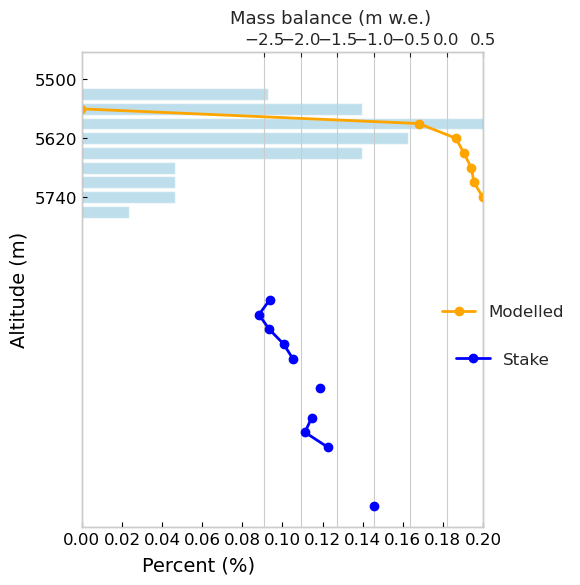

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 设置全局字体大小为12
plt.rcParams['font.size'] = 12  # 设置全局字体大小
plt.rcParams['axes.labelsize'] = 13  # 设置坐标轴标签字体大小
plt.rcParams['font.family'] = 'Arial'

model_mb = model_result
# 计算百分比
model_mb['percent'] = model_mb['count'] / model_mb['count'].sum()

# 创建图形和第一个坐标轴
fig, ax1 = plt.subplots(figsize=(6, 6))
sns.set_style("whitegrid")  

# 在ax1上绘制百分比的条形图
sns.barplot(x='percent', y='H_zone', data=model_mb, ax=ax1, alpha=0.6, color='skyblue')

# 设置轴标签
ax1.set_xlabel('Percent (%)', fontsize=14,loc='left')
ax1.set_ylabel('Altitude (m)', fontsize=14)

# 设置y轴标签和刻度每隔三个显示一个
ax1.set_yticks(model_mb['H_zone'][::4])  # 每隔三个显示一个标签
ax1.set_yticklabels(model_mb['H_zone'][::4].str[:4])  # 截取每个标签的前四个字符

# 设置x轴刻度
ax1.set_xticks(np.arange(0, model_mb['percent'].max(), 0.02))  # 调整步长
ax1.xaxis.set_label_coords(0.15,-0.06)
ax1.set_xlim(0,0.2)

# 创建第二个坐标轴，共享y轴
ax2 = ax1.twiny()

# 在ax2上绘制MB的折线图
ax2.plot(model_mb["MB_avg"], model_mb['H_zone'], color='orange', marker='o', label='Modelled', linestyle='-', linewidth=2)

# 设置ax2的标签
ax2.set_xlabel("Mass balance (m w.e.)",loc='right')

# 设置ax2的x轴反向
ax2.set_xlim(-5,0.5)
ax2.xaxis.set_label_coords(0.87, 1.06)

# 设置x-ticks
ax2.set_xticks(np.arange(-2.5,1,0.5)) 
ax2.tick_params(direction='in')
ax1.tick_params(direction='in')

# 创建第三个坐标轴，共享y轴
ax3 = ax1.twiny()

# 在ax3上绘制MB的折线图，使用不同的颜色
ax3.plot(mb_stake["MB"], mb_stake['H_zone'], 
         color='blue', marker='o', label='Stake', linestyle='-', linewidth=2)

# 设置 ax3 的范围与 ax2 一致
ax3.set_xlim(ax2.get_xlim())

# 隐藏 ax3 的标签和刻度
ax3.xaxis.set_visible(False)  # 隐藏坐标轴
ax3.tick_params(axis='x', which='both', bottom=False, top=False)  # 禁用刻度线

ax1.grid(False, axis='x')  # 关闭x方向的网格线

# 设置图例，合并ax2和ax3的图例
# 将图例放置在右侧中间的位置
ax2.legend(loc='upper center', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax3.legend(loc='upper center', bbox_to_anchor=(1.05, 0.4), frameon=False)

# 调整布局
plt.tight_layout()

# 显示图表
plt.savefig('FIG.png', dpi=600)
plt.show()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

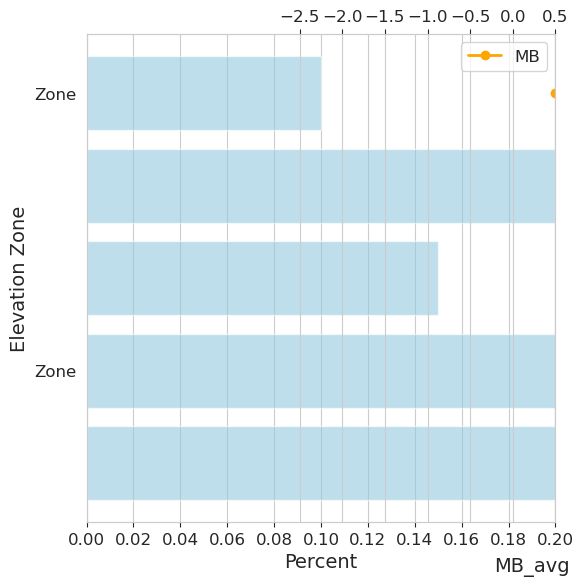

In [5]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample data for illustration (replace with your actual DataFrame)
data = {
    'H_zone': ['Zone A', 'Zone B', 'Zone C', 'Zone D', 'Zone E'],
    'count': [10, 20, 15, 25, 30],
    'MB_avg': [0.5, 1.5, 1.0, 2.5, 3.0]
}
df_plot = pd.DataFrame(data)

# Calculate percentage
df_plot['percent'] = df_plot['count'] / df_plot['count'].sum()

# Set the font to Arial globally
plt.rcParams['font.family'] = 'Arial'

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot the barplot
sns.barplot(x='percent', y='H_zone', data=df_plot, ax=ax1, alpha=0.6, color='skyblue')

# Set axis labels
ax1.set_xlabel('Percent', fontsize=14)
ax1.set_ylabel('Elevation Zone', fontsize=14)

# Set y-axis labels and show every third label
ax1.set_yticks(df_plot['H_zone'][::3])  # Show every third label
ax1.set_yticklabels(df_plot['H_zone'][::3].str[:4], fontsize=12)  # Show first four characters of each label

# Set x-ticks for ax1 with numpy.arange() for floating-point steps
ax1.set_xticks(np.arange(0, df_plot['percent'].max(), 0.02))  # Adjust step size here
ax1.set_xlim(0, 0.2)

# Adjust x-tick labels font size using tick_params
ax1.tick_params(axis='x', labelsize=12)  # Set the font size for x-tick labels

# Create the second axis, sharing the y-axis
ax2 = ax1.twiny()

# Plot the line plot on ax2
ax2.plot(df_plot["MB_avg"], df_plot['H_zone'], color='orange', marker='o', label='MB', linestyle='-', linewidth=2)

# Adjust the xlabel position on ax2:
ax2.set_xlabel("MB_avg", fontsize=14, loc='center')  # Center the label

# Manually adjust the label position to be to the right, but still centered
ax2.xaxis.set_label_coords(0.95, -0.1)  # Adjusted to be rightward (0.95 is towards the right, -0.1 for vertical shift)

# Reverse the x-axis on ax2 by setting limits and ticks accordingly
ax2.set_xlim(-5, 0.5)  # Reverse the x-axis direction

# Set x-ticks for ax2, with a step size for better visualization
ax2.set_xticks(np.arange(-2.5, 1, 0.5))

# Add legend
ax2.legend(loc='upper right', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
